In [15]:
#import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#import evaluation metrics
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_auc_score

##import function to split data
from sklearn.model_selection import train_test_split

##import tools for prepocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

#classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

In [16]:
#display all rows and columns when printing dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [17]:
#load the cleaned training dataset from a CSV file into a pandas dataframe
df = pd.read_csv('../data/training_data_cleaned.csv')

In [18]:
#separate features and target
target_col = 'DiagPeriodL90D'
X = df.drop(target_col, axis=1)
y = df[target_col]

In [19]:
#all categorical columns in the feature set (X) by selecting columns with data types 'object' or 'category'
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [20]:
##apply one-hot encoding to categorical columns (dropping the first category) while leaving other columns unchanged
ct = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'  # leave other columns unchanged
)

In [21]:
#fit & transform features
X_encoded = ct.fit_transform(X)

In [22]:
#get encoded feature names and combine with numerical columns for the final dataframe
ohe = ct.named_transformers_['onehot']
ohe_features = ohe.get_feature_names_out(categorical_cols)
numerical_cols = [col for col in X.columns if col not in categorical_cols]
feature_names = list(ohe_features) + numerical_cols

X_encoded_df = pd.DataFrame(X_encoded, columns=feature_names)


In [23]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded_df, y, test_size=0.2, random_state=42, stratify=y
)

In [24]:
#scale features for models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [25]:
#dictionary of classification models
models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
}


In [26]:
for name, model in models.items():
    print(f"\n {name} ")
    print('-----'*5)

    #scaled data only for KNN and Logistic Regression
    if name in ['KNN', 'Logistic Regression']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

    #confusion matrix
    print("Accuracy: ", round(accuracy_score(y_test, y_pred), 2))
    print("Recall:   ", round(recall_score(y_test, y_pred, average='macro'), 2))
    print("ROC AUC:  ", round(roc_auc_score(y_test, y_proba), 2))



 KNN 
-------------------------
Accuracy:  0.58
Recall:    0.54
ROC AUC:   0.55

 Logistic Regression 
-------------------------
Accuracy:  0.61
Recall:    0.54
ROC AUC:   0.61

 Gradient Boosting 
-------------------------
Accuracy:  0.63
Recall:    0.55
ROC AUC:   0.64


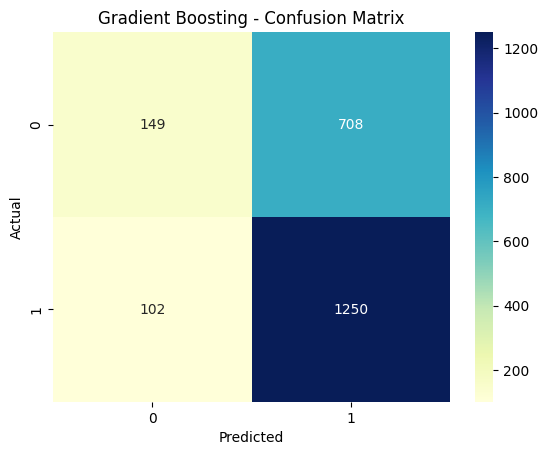

In [27]:
    #display confusion matrix for the best model only
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
